# CESM2, ERA5 wind speed comparison

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

# %load_ext line_profiler

In [2]:
base_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
era5_dir  = f'{base_dir}ERA5-forcing/climatology/'
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/ensemble_mean/'

mesh_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250715.nc').squeeze().isel(nav_lev=0)
domcfg    = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20250715.nc').squeeze()
distcoast = xr.open_dataset(f'{base_dir}bathymetry/distance_coast-20250715.nc')

ERA5_angle   = xr.open_dataset(f'{era5_dir}ERA5_eANT025_wind_angle_3-hourly_1979-2024_mean_monthly.nc').where(mesh_mask.tmask!=0)
ERA5_speed   = xr.open_dataset(f'{era5_dir}ERA5_eANT025_wind_speed_3-hourly_1979-2024_mean_monthly.nc').where(mesh_mask.tmask!=0)
CESM2_angle  = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_eANT025_wind_angle_3-hourly_ensemble_1979-2024_mean_monthly.nc').where(mesh_mask.tmask!=0)
CESM2_speed  = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_eANT025_wind_speed_3-hourly_ensemble_1979-2024_mean_monthly.nc').where(mesh_mask.tmask!=0)
CESM2_speed_corr = xr.open_dataset(f'{cesm2_dir}bias_corr/CESM2-LE2_wind_speed_3-hourly_bias_corr_monthly.nc').where(mesh_mask.tmask!=0)

In [3]:
region_mask =(distcoast.distance_coast < 100)*(mesh_mask.nav_lat < -58)

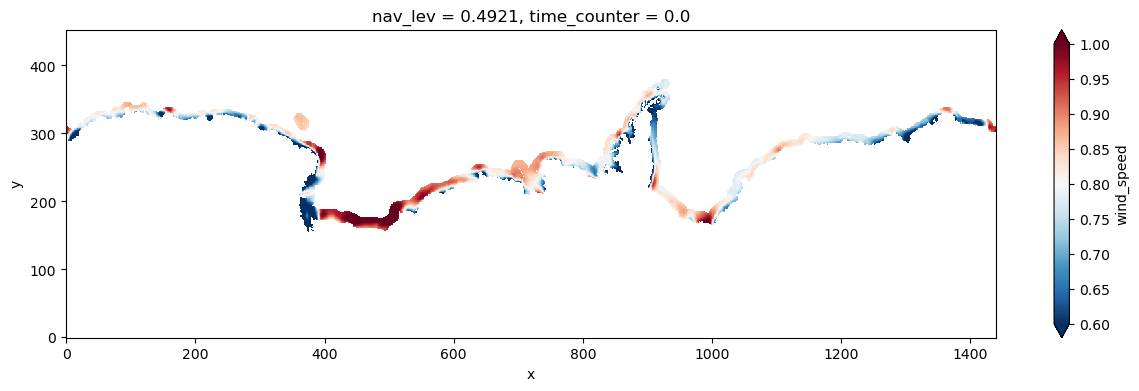

In [35]:
ratio = ERA5_speed.where(region_mask).wind_speed/CESM2_speed.where(region_mask).wind_speed
(ratio.mean(dim='month')).plot(figsize=(15,4), vmin=0.6, vmax=1, cmap='RdBu_r')

In [4]:
cesm_dir = f'{base_dir}climate-forcing/CESM2/LE2/bias-corrected/ens1011.001/seasonal_angle/'
cesm2_u = xr.open_mfdataset(f'{cesm_dir}CESM2-LE2_ens1011.001_eANT025_3-hourly_UBOT_bias_corr_monthly_2D_y192*.nc')
cesm2_v = xr.open_mfdataset(f'{cesm_dir}CESM2-LE2_ens1011.001_eANT025_3-hourly_VBOT_bias_corr_monthly_2D_y192*.nc')

In [5]:
cesm2_speed = np.hypot(cesm2_u.UBOT, cesm2_v.VBOT).groupby('time_counter.month').mean()
cesm2_angle = np.arctan2(cesm2_v.VBOT, cesm2_u.UBOT).groupby('time_counter.month').mean()

In [ ]:
cesm2_speed.compute()

In [ ]:
cesm2_speed.rename('wind_speed').to_dataset().to_netcdf(f'{cesm_dir}../CESM2_wind_speed_seasonal_angle_1920s_mean.nc')

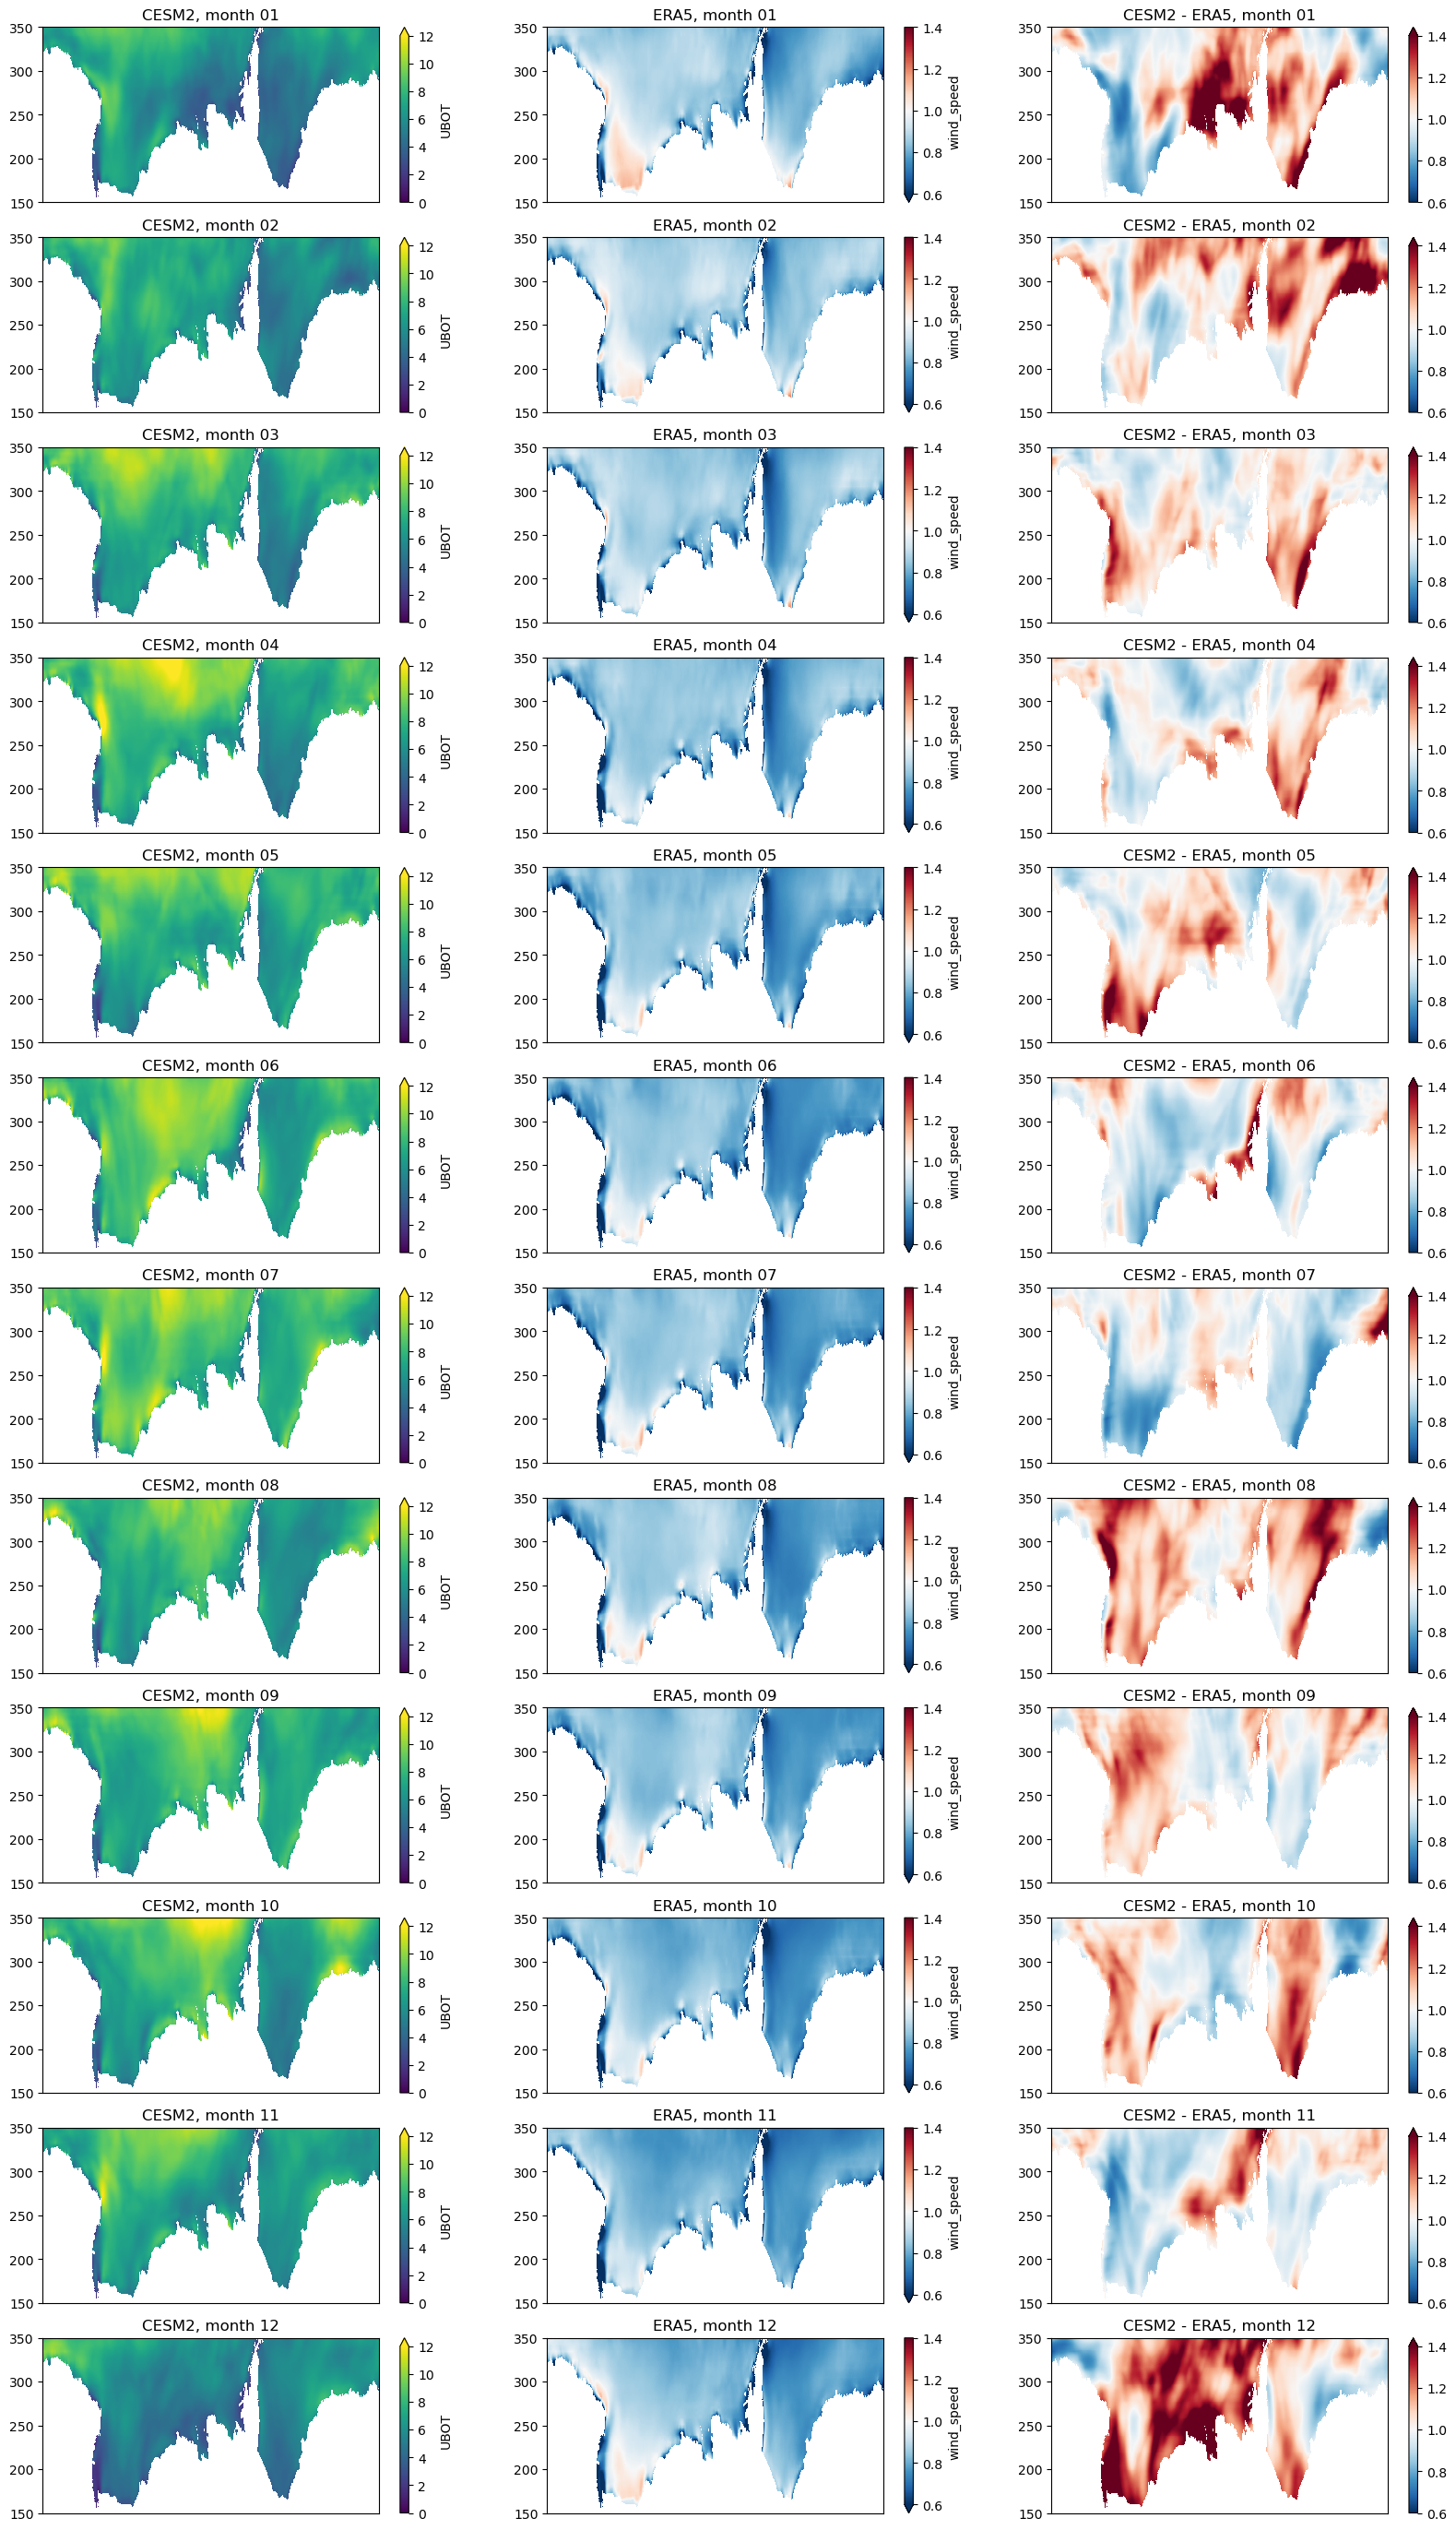

In [42]:
fig, ax = plt.subplots(12,3,figsize=(20,35))

for m, month in enumerate(range(0,12)):
    cesm2_speed.isel(month=month).where(mesh_mask.tmask!=0).plot(ax=ax[m,0], vmin=0, vmax=12)
    CESM2_speed_corr.wind_speed.isel(month=month).plot(ax=ax[m,1], vmin=0.6, vmax=1.0, cmap='RdBu_r')
    (ERA5_speed.wind_speed.isel(month=month)/cesm2_speed.isel(month=month)).plot(ax=ax[m,2], cmap='RdBu_r', vmin=0.6, vmax=1.4)
    
    ax[m,0].set_title(f'CESM2, month {m+1:02}')
    ax[m,1].set_title(f'ERA5, month {m+1:02}')
    ax[m,2].set_title(f'ERA5/CESM2, month {m+1:02}')
    
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');
    axis.set_xticks([])
    axis.set_xlim(200, 1300)
    axis.set_ylim(150, 350)

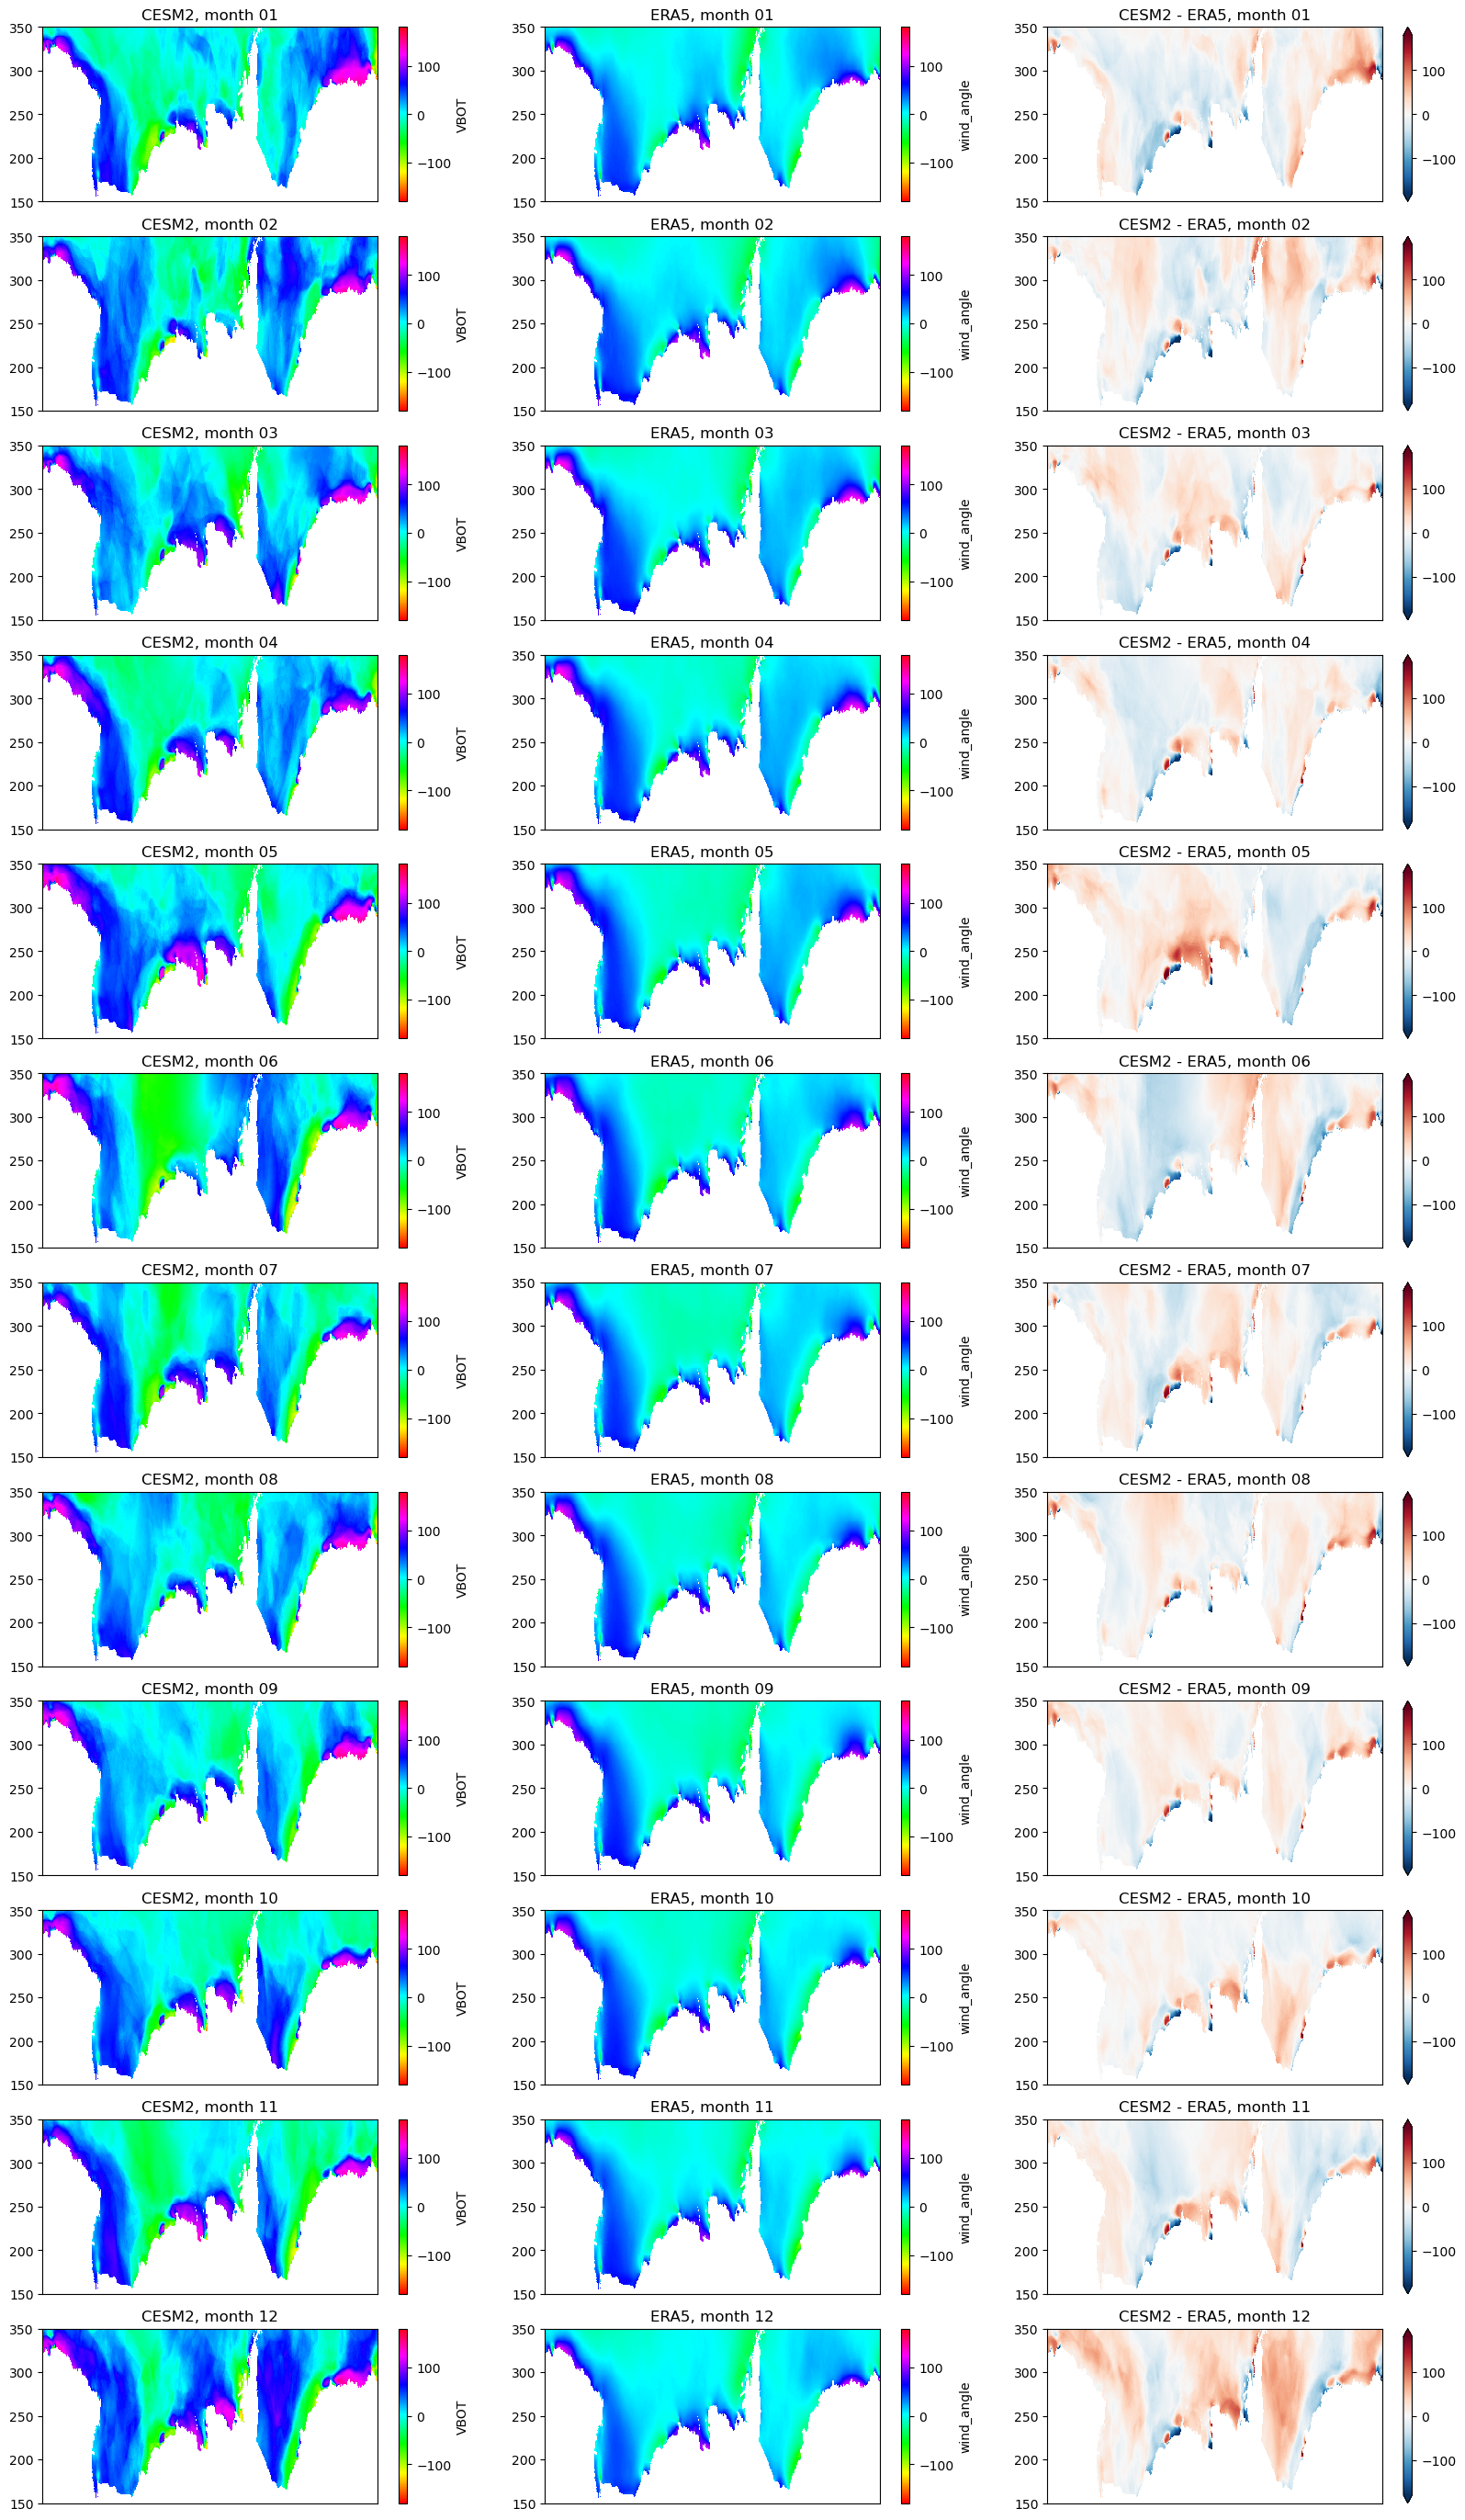

In [7]:
fig, ax = plt.subplots(12,3,figsize=(20,35))

for m, month in enumerate(range(0,12)):
    np.rad2deg(cesm2_angle.isel(month=month)).where(mesh_mask.tmask!=0).plot(ax=ax[m,0], vmin=-180, vmax=180, cmap='hsv')
    np.rad2deg(ERA5_angle.wind_angle.isel(month=month)).plot(ax=ax[m,1], vmin=-180, vmax=180, cmap='hsv')
    (np.rad2deg(cesm2_angle.isel(month=month)) - np.rad2deg(ERA5_angle.wind_angle.isel(month=month))).plot(ax=ax[m,2], cmap='RdBu_r', vmin=-180, vmax=180)
    
    ax[m,0].set_title(f'CESM2, month {m+1:02}')
    ax[m,1].set_title(f'ERA5, month {m+1:02}')
    ax[m,2].set_title(f'CESM2 - ERA5, month {m+1:02}')
    
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');
    axis.set_xticks([])
    axis.set_xlim(200, 1300)
    axis.set_ylim(150, 350)

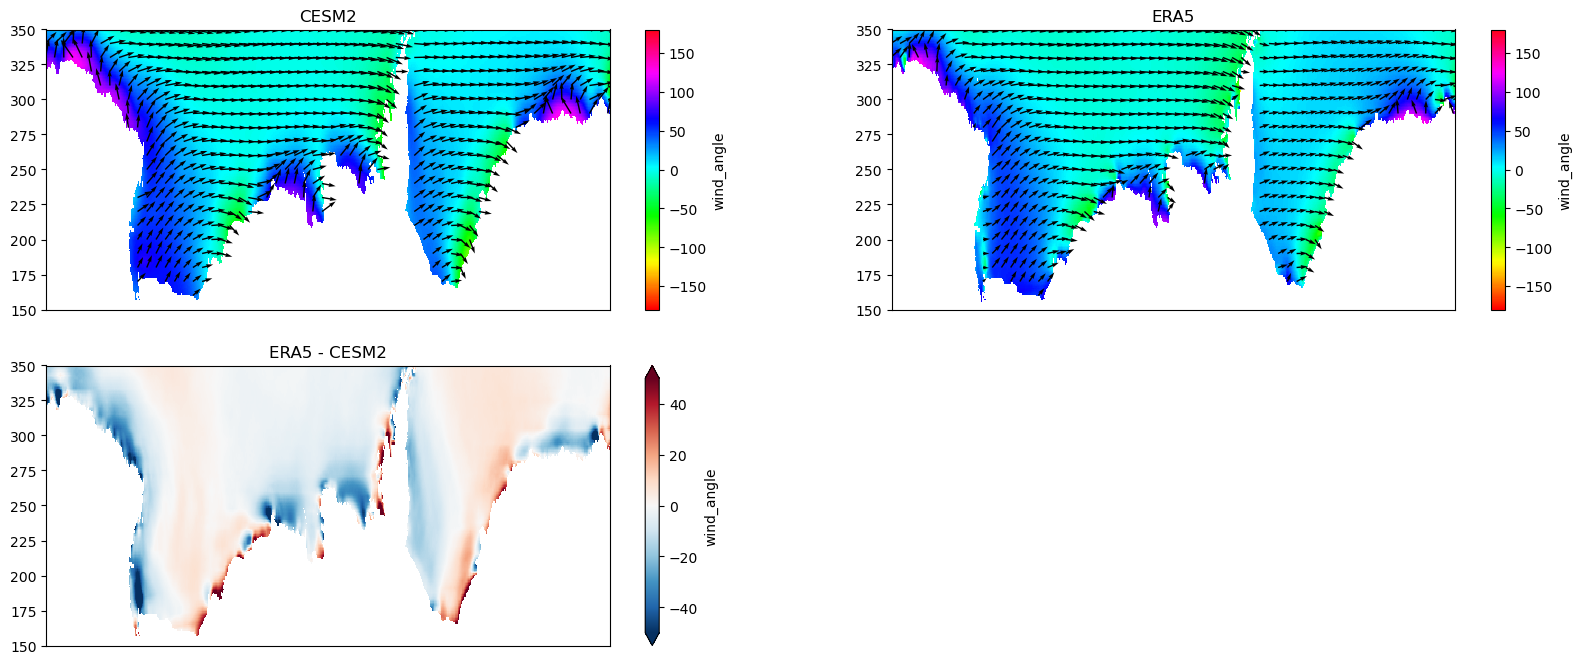

In [65]:
fig, ax = plt.subplots(2,2,figsize=(20,8))

np.rad2deg(CESM2_angle.wind_angle.mean(dim='month')).plot(ax=ax[0,0], cmap='hsv', vmin=-180, vmax=180)
np.rad2deg(ERA5_angle.wind_angle.mean(dim='month')).plot(ax=ax[0,1], cmap='hsv', vmin=-180, vmax=180)
np.rad2deg((ERA5_angle.wind_angle.mean(dim='month') - CESM2_angle.wind_angle.mean(dim='month'))).plot(ax=ax[1,0], cmap='RdBu_r', vmin=-50, vmax=50)

xind=18; yind=10;
ql = ax[0,0].quiver(CESM2_angle.x.values[::xind], CESM2_angle.y.values[::yind],
                    CESM2_u.mean(dim='month').values[::yind,::xind], CESM2_v.mean(dim='month').values[::yind,::xind],
                    width=2.5e-3, scale=310, color='k')
ql = ax[0,1].quiver(ERA5_angle.x.values[::xind], ERA5_angle.y.values[::yind],
                    ERA5_u.mean(dim='month').values[::yind,::xind], ERA5_v.mean(dim='month').values[::yind,::xind],
                    width=2.5e-3, scale=310, color='k')
ax[0,0].set_title('CESM2')
ax[0,1].set_title('ERA5')
ax[1,0].set_title('ERA5 - CESM2')
    
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');
    axis.set_xticks([])
    axis.set_xlim(200, 1300)
    axis.set_ylim(150, 350)
ax[1,1].remove()